## Imports

In [7]:
import leafmap
import geopandas as gpd
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
import json
from shapely import wkt

## Loading xBD Data 

In [8]:
fire_name = "pinery"
fire_type = "bushfire"
pic_number = "0022"
pre_image_f = f"../fires/{fire_name}/images/{fire_name}-{fire_type}_0000{pic_number}_pre_disaster.tif"
post_image_f = f"../fires/{fire_name}/images/{fire_name}-{fire_type}_0000{pic_number}_post_disaster.tif"
pre_label_f = f"../fires/{fire_name}/labels/{fire_name}-{fire_type}_0000{pic_number}_pre_disaster.json"
post_label_f = f"../fires/{fire_name}/labels/{fire_name}-{fire_type}_0000{pic_number}_post_disaster.json"

pre_image = rasterio.open(pre_image_f)
post_image = rasterio.open(post_image_f)

pre_image_data = pre_image.read([1,2,3])
pre_image_data = pre_image_data.transpose(1,2,0)
post_image_data = post_image.read([1,2,3])
post_image_data = post_image_data.transpose(1,2,0)

with open(pre_label_f, 'r') as f:
    pre_label_data = json.load(f)

with open(post_label_f, 'r') as f:
    post_label_data = json.load(f)

In [3]:
def inspect_tif(path):
    with rasterio.open(path) as src:
        print(f"\n📂 Inspecting: {path}")
        print("Shape (height, width):", (src.height, src.width))
        print("Number of bands:", src.count)
        res_x, res_y = src.res
        print("Pixel size (X):", res_x)
        print("Pixel size (Y):", res_y)
        print("CRS:", src.crs)
        print("Affine Transform:", src.transform)
        print("Band order and descriptions:")
        print()

        for i in range(1, src.count + 1):
            desc = src.descriptions[i-1] or f"Band {i}"
            dtype = src.dtypes[i-1]
            stats = src.read(i).min(), src.read(i).max()
            shape = src.read(i).shape
            print(f"  - Band {i}: {desc}, dtype: {dtype}, min-max: {stats}, shape: {shape}")

In [4]:
inspect_tif(pre_image_f)


📂 Inspecting: ../fires/pinery/images/pinery-bushfire_00000008_pre_disaster.tif
Shape (height, width): (1024, 1024)
Number of bands: 3
Pixel size (X): 4.549830917562344e-06
Pixel size (Y): 4.549830917562344e-06
CRS: EPSG:4326
Affine Transform: | 0.00, 0.00, 138.75|
| 0.00,-0.00,-34.52|
| 0.00, 0.00, 1.00|
Band order and descriptions:

  - Band 1: Band 1, dtype: int16, min-max: (np.int16(16), np.int16(241)), shape: (1024, 1024)
  - Band 2: Band 2, dtype: int16, min-max: (np.int16(12), np.int16(239)), shape: (1024, 1024)
  - Band 3: Band 3, dtype: int16, min-max: (np.int16(8), np.int16(237)), shape: (1024, 1024)


In [5]:
import rasterio
import numpy as np

def normalize_to_uint8_per_band(image_path, export=False, export_path="norm_img.tif"):
    """
    Normalizes a multi-band image to 0–255 per band and converts to uint8.
    Expects a path to a .tif file.
    If export=True, saves normalized image to a GeoTIFF at `export_path`.
    Returns: normalized image (H, W, C) as uint8
    """

    with rasterio.open(image_path) as src:
        image = src.read([1, 2, 3])  # shape: (C, H, W)
        meta = src.meta.copy()

    # Transpose to (H, W, C)
    if image.shape[0] in [1, 2, 3, 4, 5]:  # (C, H, W) → (H, W, C)
        image = np.transpose(image, (1, 2, 0))

    norm_image = np.zeros_like(image, dtype=np.uint8)

    for i in range(image.shape[2]):
        band = image[:, :, i].astype(np.float32)
        band -= band.min()
        if band.max() > 0:
            band /= band.max()
        band *= 255
        norm_image[:, :, i] = band.astype(np.uint8)

    if export:
        # Update metadata after we're sure norm_image is final
        meta.update({
            'count': norm_image.shape[2],
            'dtype': 'uint8'
        })

        meta.update({'nodata': 0})

        # Transpose back to (C, H, W) for writing
        norm_image_raster = norm_image.transpose(2, 0, 1)

        with rasterio.open(export_path, 'w', **meta) as dst:
            dst.write(norm_image_raster)

    return norm_image


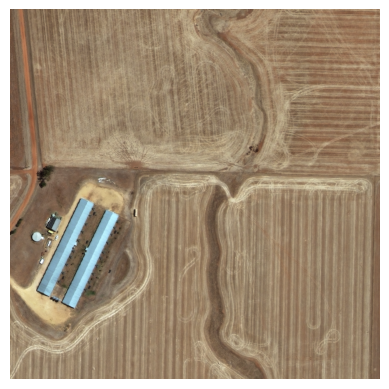

In [14]:
norm_pre = normalize_to_uint8_per_band(pre_image_f, export=False)
plt.imshow(norm_pre)
plt.axis("off")
plt.show()

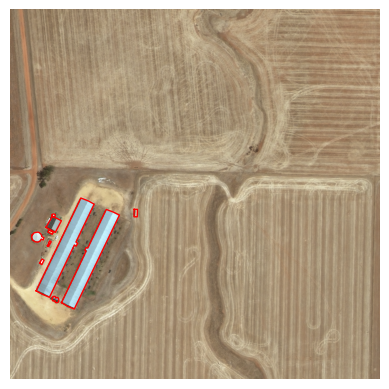

In [14]:
# Example: draw the first structure
poly = wkt.loads(pre_label_data['features']['xy'][0]['wkt'])

# Plot
fig, ax = plt.subplots()
ax.imshow(pre_image_data)  # your loaded and transposed image

for feature in pre_label_data['features']['xy']:
    poly = wkt.loads(feature['wkt'])
    x, y = poly.exterior.xy
    ax.plot(x, y, color='red', linewidth=1)

plt.axis('off')
plt.show()


In [90]:
with open(post_label_f, "r") as f:
        lab_data = json.load(f)

In [91]:
lab_data

{'features': {'lng_lat': [{'properties': {'feature_type': 'building',
     'subtype': 'no-damage',
     'uid': '92e0e2e4-b9ce-488a-ad3e-65463fd5dbf2'},
    'wkt': 'POLYGON ((138.7423071217068 -34.38393140784416, 138.7423967828768 -34.38380949325098, 138.7424648203855 -34.38383438612524, 138.742521604586 -34.38386062123318, 138.7424342223979 -34.38399129828477, 138.7423071217068 -34.38393140784416))'},
   {'properties': {'feature_type': 'building',
     'subtype': 'no-damage',
     'uid': '17c061a0-ea18-474b-ba8a-51b2695ebeb4'},
    'wkt': 'POLYGON ((138.7423931591859 -34.38380429307124, 138.7423907978584 -34.38379176131037, 138.7423941489149 -34.38378418114601, 138.7424153767072 -34.38378065876065, 138.7424299278216 -34.38378297763803, 138.7424389658321 -34.38378966813182, 138.7424370626799 -34.38380193478937, 138.742434800157 -34.38381083978145, 138.7424250525794 -34.38381382850586, 138.7424068460659 -34.38381367884534, 138.7423944073886 -34.38380804392408, 138.7423931591859 -34.38380

## Plotting

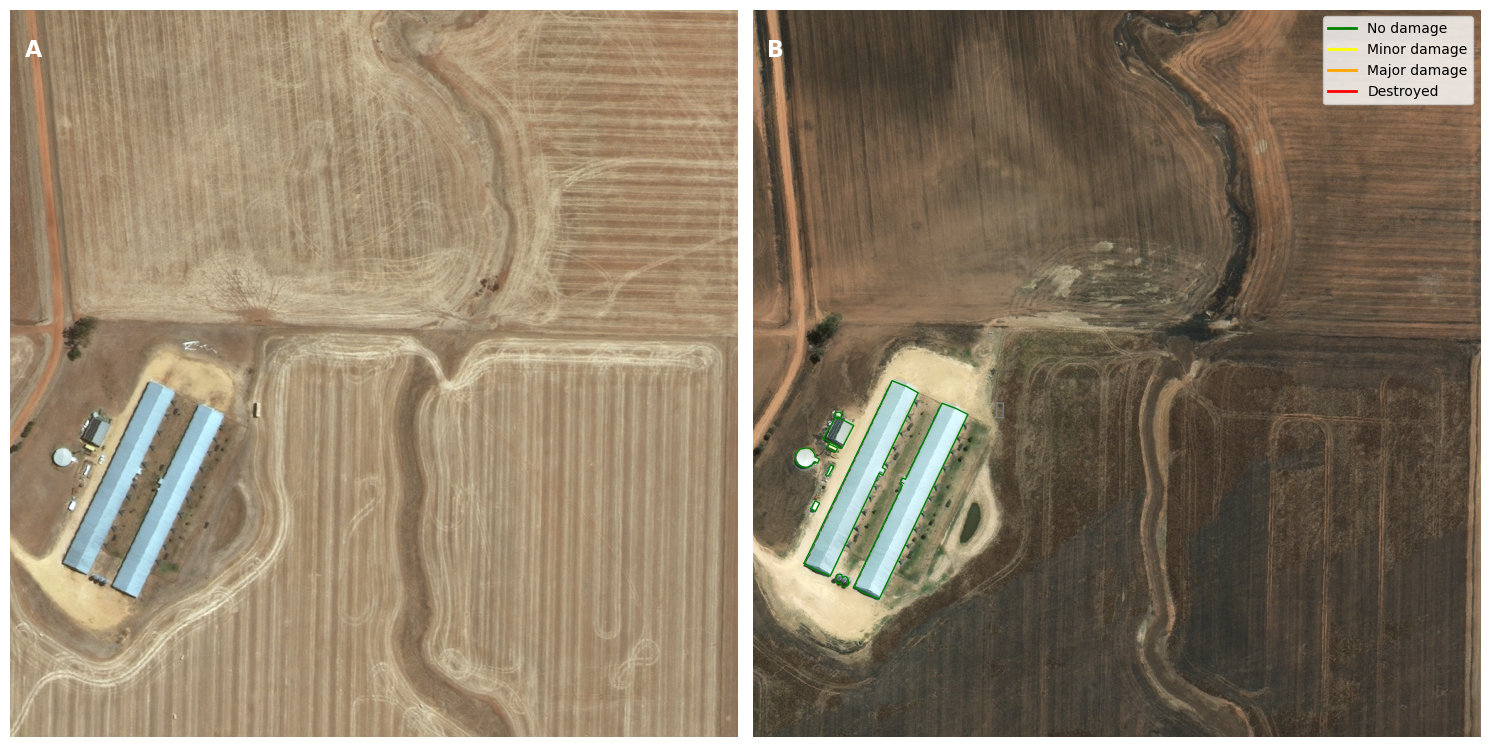

In [97]:
# Define a color map for damage levels
damage_colors = {
    "no-damage": "green",
    "minor-damage": "yellow",
    "major-damage": "orange",
    "destroyed": "red"
}

fig, axes = plt.subplots(1, 2, figsize=(15, 8)) # Changed from (1, 3) to (1, 2)

axes[0].imshow(pre_image_data)
axes[0].axis('off')
axes[0].text(
        0.02, 0.96, "A",                # (x, y) in axes fraction coordinates
        transform=axes[0].transAxes,               # makes coordinates relative to axes (0–1)
        fontsize=16, fontweight='bold',
        va='top', ha='left', color='white'    # align top-left
    )


ax = axes[1]

ax.imshow(post_image_data)

for feature in post_label_data['features']['xy']:
    damage_level = feature['properties'].get('subtype', 'no-damage')
    poly = wkt.loads(feature['wkt'])
    x, y = poly.exterior.xy
    color = damage_colors.get(damage_level, 'gray')  # fallback if unknown
    ax.plot(x, y, color=color, linewidth=1)

# Optional: add legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color=color, lw=2, label=label.replace('-', ' ').capitalize())
    for label, color in damage_colors.items()
]

ax.legend(handles=legend_elements)
ax.axis('off')
ax.text(
        0.02, 0.96, "B",                # (x, y) in axes fraction coordinates
        transform=ax.transAxes,               # makes coordinates relative to axes (0–1)
        fontsize=16, fontweight='bold',
        va='top', ha='left', color='white'    # align top-left
    )


#axes[2].imshow(ann_img_data)
#axes[2].axis('off')
#axes[2].text(
#        0.02, 0.96, "C",                # (x, y) in axes fraction coordinates
#        transform=axes[2].transAxes,               # makes coordinates relative to axes (0–1)
#        fontsize=16, fontweight='bold',
#        va='top', ha='left', color='white'    # align top-left
#    )


plt.tight_layout()
#plt.savefig("xBD_Analysis.png", dpi=300, bbox_inches="tight")
plt.show()


## Generating Candidate Image CSV

In [101]:
import json
from pathlib import Path
import pandas as pd
import os

In [112]:
ROOT = Path("../fires")  # change if needed
GLOB_PATTERNS = [
    "**/labels/*_post_disaster.json",  # find post labels everywhere under ROOT
]

CSV_OUT = Path("xBD_WUI_Analysis.csv")

# Columns to keep in the master index (pre-fill some; update later in your pipeline)
INDEX_COLUMNS = [
    "scene_id",
    "fire_name",
    "pre_image_path",
    "post_image_path",
    "post_label_path",
    "gpkg_path",
    "n_structures_total",
    "n_major_or_destroyed",
    "segmented",
    "n_polygons",
    "pct_black",
    "pct_segmented",
    "classified",
    "classification_mode",
]

DAMAGE_HARD = {"major-damage", "destroyed"}

In [103]:
def parse_label_counts(json_path: Path):
    """Return (total_buildings, major_or_destroyed) from an xBD post label JSON."""
    with open(json_path, "r") as f:
        data = json.load(f)

    feats = data.get("features", {}).get("xy", [])
    total = 0
    hard = 0
    for feat in feats:
        props = (feat or {}).get("properties", {})
        if props.get("feature_type") != "building":
            continue
        total += 1
        subtype = props.get("subtype", "").lower()
        if subtype in DAMAGE_HARD:
            hard += 1
    return total, hard

In [62]:
total, hard = parse_label_counts(post_label_f)

In [121]:
def infer_paths_from_label(label_path: Path):
    """
    From a *_post_disaster.json, infer:
      - fire_name (parent of labels/)
      - scene_id (stem without extension, or nicer shortened id)
      - pre/post image paths
      - default gpkg path you plan to write later
    """
    fire_name = label_path.parents[1].name  # e.g., 'santa-rosa'
    stem = label_path.stem                  # e.g., 'santa-rosa-wildfire_0000XXXX_post_disaster'
    # Derive corresponding pre/post image filenames by replacing suffix
    post_img = label_path.parents[1] / "images" / (stem.replace("_post_disaster", "_post_disaster") + ".tif")
    pre_img  = label_path.parents[1] / "images" / (stem.replace("_post_disaster", "_pre_disaster") + ".tif")

    # Scene id: fire + number chunk (customize if you want)
    # Try to keep something like 'santa-rosa_0000XXXX'
    parts = stem.split("_")
    number = parts[1][4:]
    scene_id = f"{fire_name}_{number}"

    gpkg_path = Path("./Analysed_Images") / f"{scene_id}_polygons.gpkg"
    return fire_name, scene_id, pre_img, post_img, gpkg_path

In [105]:
def find_post_label_files(root: Path):
    files = []
    for pat in GLOB_PATTERNS:
        files.extend(root.glob(pat))
    return sorted(files)

In [81]:
label_files = find_post_label_files(ROOT)

In [99]:
str(label_files[0])

'../fires/pinery/labels/pinery-bushfire_00000000_post_disaster.json'

In [84]:
fire_name, scene_id, pre_img, post_img, gpkg_path = infer_paths_from_label(label_files[21])

In [85]:
post_img

PosixPath('../fires/pinery/images/pinery-bushfire_00000021_post_disaster.tif')

In [68]:
gpkg_path

PosixPath('Analysed_Images/pinery_0021_polygons.gpkg')

In [ ]:
def generate_candidates(min_buildings=5, min_hard=2):
    rows = []
    per_fire_counts = {}   # {fire_name: count_of_candidates}

    label_files = find_post_label_files(ROOT)
    for lbl in label_files:
        try:
            total, hard = parse_label_counts(lbl)
        except Exception as e:
            print(f"[WARN] Failed parsing {lbl}: {e}")
            continue

        # Apply your filter
        if total >= min_buildings and hard >= min_hard:
            fire_name, scene_id, pre_img, post_img, gpkg_path = infer_paths_from_label(lbl)

            # Track per-fire counts
            per_fire_counts[fire_name] = per_fire_counts.get(fire_name, 0) + 1

            # Build row with placeholders for fields you’ll fill later
            row = {
                "scene_id": scene_id,
                "fire_name": fire_name,
                "pre_image_path": str(pre_img),
                "post_image_path": str(post_img),
                "post_label_path": str(lbl),
                "gpkg_path": str(gpkg_path),
                "n_structures_total": total,
                "n_major_or_destroyed": hard,
                "segmented": False,
                "n_polygons": None,
                "pct_black": None,
                "pct_segmented": None,
                "classified": False,
                "classification_mode": None,
            }
            rows.append(row)

    # Create dataframe in your desired column order
    df = pd.DataFrame(rows, columns=INDEX_COLUMNS)

    # Save CSV (atomic write)
    CSV_OUT.parent.mkdir(parents=True, exist_ok=True)
    tmp = CSV_OUT.with_suffix(".csv.tmp")
    df.to_csv(tmp, index=False)
    tmp.replace(CSV_OUT)

    # Print per-fire summary
    if per_fire_counts:
        print("\nCandidates per fire (>= {min_buildings} buildings & >= {min_hard} major/destroyed):")
        for k in sorted(per_fire_counts):
            print(f"  {k}: {per_fire_counts[k]}")
        print(f"\nTotal candidates: {sum(per_fire_counts.values())}")
        print(f"CSV written: {CSV_OUT}")
    else:
        print("No candidates matched the criteria.")

    return df


In [129]:
final_df = generate_candidates(min_buildings=2, min_hard=1)


Candidates per fire (>= {min_buildings} buildings & >= {min_hard} major/destroyed):
  pinery: 112
  portugal: 323
  santa-rosa: 253
  socal: 301
  woolsey: 278

Total candidates: 1267
CSV written: xBD_WUI_Analysis.csv


In [136]:
CSV = Path("xBD_WUI_Analysis.csv")
df_q = pd.read_csv(CSV)

In [141]:
row = df_q.iloc[0]
row

scene_id                                                      pinery_0032
fire_name                                                          pinery
pre_image_path          ../fires/pinery/images/pinery-bushfire_0000003...
post_image_path         ../fires/pinery/images/pinery-bushfire_0000003...
post_label_path         ../fires/pinery/labels/pinery-bushfire_0000003...
gpkg_path                       Analysed_Images/pinery_0032_polygons.gpkg
n_structures_total                                                     35
n_major_or_destroyed                                                   11
segmented                                                           False
n_polygons                                                            NaN
pct_black                                                             NaN
pct_segmented                                                         NaN
classified                                                          False
classification_mode                   

In [ ]:
tmp = CSV.with_suffix(".csv.tmp")
df_q.to_csv(tmp, index=False)
os.replace(tmp, CSV)   # atomic rename on the same filesystem

In [133]:
import pandas as pd
from pathlib import Path
import os

CSV = Path("xBD_WUI_Analysis.csv")

df = pd.read_csv(CSV)

# Optional: fix dtype if the column came in as string
df["n_major_or_destroyed"] = pd.to_numeric(df["n_major_or_destroyed"], errors="coerce").fillna(0).astype(int)

# 1) Decide the order of fires to cycle through
#    Option A: explicit order (recommended, stable)
fire_order = ["pinery", "santa-rosa", "woolsey", "portugal", "socal"]  # <- put your 5 names here in the order you want

#    Option B: derive order deterministically (comment out A if you prefer this)
# fire_order = (
#     df.groupby("fire_name")["n_major_or_destroyed"]
#       .sum().sort_values(ascending=False)
#       .index.tolist()
# )

# Map fire_name -> ordinal so we can sort later
fire_rank = {name: i for i, name in enumerate(fire_order)}
df["fire_order"] = df["fire_name"].map(fire_rank)

# 2) Sort within each fire by n_major_or_destroyed (desc), then assign position 0,1,2,...
df = (df.sort_values(["fire_name", "n_major_or_destroyed"], ascending=[True, False])
        .assign(pos=lambda x: x.groupby("fire_name").cumcount()))

# 3) Interleave: sort by the round index (pos), then by fire_order
#    (Rows from different fires with the same pos will appear together in fire_order sequence)
df_roundrobin = df.sort_values(["pos", "fire_order"]).drop(columns=["pos", "fire_order"]).reset_index(drop=True)

# 4) Save atomically
tmp = CSV.with_suffix(".csv.tmp")
df_roundrobin.to_csv(tmp, index=False, lineterminator="\n")
os.replace(tmp, CSV)


## Unused Functions

In [ ]:
def export_xbd_json_to_shapefile(json_path, output_path):
    # Load the JSON
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Extract features from 'xy' block (pixel-based)
    # features = data['features']['xy']
    features  = data['features']['lng_lat']  # If you want to use 'lng_lat' instead

    geometries = []
    attributes = []

    for feature in features:
        # Parse WKT geometry
        geom = wkt.loads(feature['wkt'])
        geometries.append(geom)

        # Get properties (like damage subtype and uid)
        props = feature.get('properties', {})
        attributes.append(props)

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(attributes, geometry=geometries)

    # Set CRS — if you're in pixel space, leave it undefined (or set it manually if needed)
    # If you switch to 'lng_lat' instead of 'xy', then:
    gdf.set_crs("EPSG:4326", inplace=True)

    # Save to shapefile
    gdf.to_file(output_path, driver='ESRI Shapefile')
    print(f"✅ Saved to {output_path}")


In [ ]:
def reproject_raster_to_utm(src_path, dst_path):
    with rasterio.open(src_path) as src:
        # Estimate target CRS (UTM zone based on image center)
        from pyproj import CRS
        utm_crs = CRS.from_user_input(src.crs).get_utm_crs(src.xy(src.height // 2, src.width // 2)[1])

        transform, width, height = calculate_default_transform(
            src.crs, utm_crs, src.width, src.height, *src.bounds
        )

        kwargs = src.meta.copy()
        kwargs.update({
            'crs': utm_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(dst_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=utm_crs,
                    resampling=Resampling.bilinear
                )
    return dst_path, utm_crs


In [18]:
export_xbd_json_to_shapefile(pre_label_f, "b_footprints.shp")

✅ Saved to b_footprints.shp
